In [21]:
# ignore all future warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

In [22]:
# imports
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [23]:
# given by the assignment
def loadData():
    with np.load('notMNIST.npz') as data :
        Data, Target = data['images'], data['labels']
        posClass = 2
        negClass = 9
        dataIndx = (Target==posClass) + (Target==negClass)
        Data = Data[dataIndx]/255.
        Target = Target[dataIndx].reshape(-1, 1)
        Target[Target==posClass] = 1
        Target[Target==negClass] = 0
        np.random.seed(421)
        randIndx = np.arange(len(Data))
        np.random.shuffle(randIndx)
        Data, Target = Data[randIndx], Target[randIndx]
        trainData, trainTarget = Data[:3500], Target[:3500]
        validData, validTarget = Data[3500:3600], Target[3500:3600]
        testData, testTarget = Data[3600:], Target[3600:]
    return trainData, validData, testData, trainTarget, validTarget, testTarget

In [24]:
trainData, validData, testData, trainTarget, validTarget, testTarget = loadData()
print(f"Training Data: {trainData.shape}\tTraining tagets: {trainTarget.shape}")
print(f"Validation Data: {validData.shape}\tValidation tagets: {validTarget.shape}")
print(f"Testing Data: {testData.shape}\tTesting tagets:{testTarget.shape}")

Training Data: (3500, 28, 28)	Training tagets: (3500, 1)
Validation Data: (100, 28, 28)	Validation tagets: (100, 1)
Testing Data: (145, 28, 28)	Testing tagets:(145, 1)


In [25]:
def plot(image, target):
    plt.imshow(image, cmap="hot")
    plt.title('J' if target == 0 else 'C')
    # targets are binary encoded 0 == 'J' and 1 == 'C'
    plt.show()

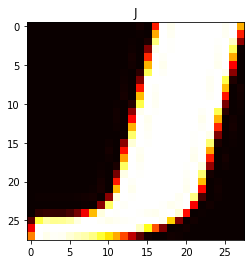

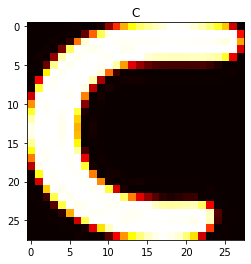

In [26]:
plot(trainData[0], trainTarget[0])
plot(trainData[1], trainTarget[1])

In [27]:
def augment(X, w, b):
    # flatten X
    if len(X.shape) == 3:
        X = X.reshape(X.shape[0], -1)
    
    # insert 1's at position 0 along the columns
    X = np.insert(X, 0, 1, axis=1)
    
    # insert b at the front of W
    w = np.insert(w, 0, b, axis=0)
    
    return X, w

In [28]:
def predict(w, b, X):
    X = X.reshape(X.shape[0], -1)
    return X.dot(w) + b

In [29]:
def accuracy(w, b, X, y):
    y = y.reshape(-1)
    y_pred = predict(w, b, X)
    y_pred = np.vectorize(lambda z: 1 if z > 0 else 0)(y_pred)
    return sum(y_pred == y) / y.shape[0]

# 1 Linear Regression
### 1. Loss Function and Gradient

In [30]:
# Mean Squared Error Loss
def MSE(w, b, X, y, reg):
    X = X.reshape(X.shape[0], -1)
    y = y.reshape(-1)
    return np.square(X.dot(w) + b - y).mean() + reg * np.square(w).sum()

def gradMSE(w, b, X, y, reg):
    X = X.reshape(X.shape[0], -1)
    y = y.reshape(-1)
    N = y.shape[0]
    
    w_grad = 2.0/N * X.T.dot(X.dot(w) + b - y) + reg * w
    b_grad = 2.0/N * np.sum(X.dot(w) + b - y)
    return w_grad, b_grad

# The below is a test for MSE Loss, which is correct (at least without the regulator)
"""
from sklearn.metrics import mean_squared_error

X = trainData
y = trainTarget
N = X.shape[0]
d = X.shape[1] * X.shape[2]

w = np.random.random_sample(d)
b = np.random.random_sample(1)

y_pred = predict(w_LS, b_LS, X)
print(mean_squared_error(y, y_pred))
print(MSE(w_LS, b_LS, X, y, 0))
"""

#gradMSE(w, b, X, y, 0.1)



'\nfrom sklearn.metrics import mean_squared_error\n\nX = trainData\ny = trainTarget\nN = X.shape[0]\nd = X.shape[1] * X.shape[2]\n\nw = np.random.random_sample(d)\nb = np.random.random_sample(1)\n\ny_pred = predict(w_LS, b_LS, X)\nprint(mean_squared_error(y, y_pred))\nprint(MSE(w_LS, b_LS, X, y, 0))\n'

### 2. Gradient Descent Implementation

In [31]:
def grad_descent_MSE(w, b, X, y, alpha, epochs, reg, error_tol, validData=None, validTarget=None, testData=None, testTarget=None):
    train_loss, train_acc = [], []
    valid_loss, valid_acc = [], []
    test_loss, test_acc = [], []
    printing = True
    for i in range(epochs):
        grad_w, grad_b = gradMSE(w, b, X, y, reg)
        w -= alpha * grad_w
        b -= alpha * grad_b
        
        # Calculating Statistics
        train_loss.append( MSE(w, b, X, y, reg) )
        train_acc.append( accuracy(w, b, X, y) )

        if validData != None and validTarget != None:
            valid_loss.append( MSE(w, b, validData, validTarget, reg) )
            valid_acc.append( accuracy(w, b, validData, validTarget) )
        if testData != None and testTarget != None:
            test_loss.append( MSE(w, b, testData, testTarget, reg) )
            valid_acc.append( accuracy(w, b, testData, testTarget) )
        
        # Print Losses and Accurancies if printing is on
        if printing:
            print(f"Training loss: {train_loss[-1]:.4f}\tTraining acc: {train_acc[-1]*100:.2f}%")
            if validData != None and validTarget != None:
                print(f"Validation loss: {valid_loss[-1]:.4f}\tValidation acc: {valid_acc[-1]*100:.2f}%")
            if testData != None and testTarget != None:
                print(f"Testing loss: {test_loss[-1]:.4f}\tTesting acc: {test_acc[-1]*100:.2f}%")

        # Check stopping condition
        if i > 1 and np.abs(train_loss[-2] - train_loss[-1]) <= error_tol:
            break

    statistics = (train_loss, train_acc)
    if validData != None and validTarget != None:
        statistics += (valid_loss, valid_acc, )
    if testData != None and testTarget != None:
        statistics += (test_loss, test_acc,)
    # Python 3.8 made this easier, but 3.7 you have to do this
    out = (w, b, *statistics)
    
    return out

X = trainData
N = X.shape[0]
d = X.shape[1] * X.shape[2]

w = np.random.random_sample(d)
b = np.random.random_sample(1)
w, b, *statistics = grad_descent_MSE(w, b, trainData, trainTarget, 0.005, 5000, 0, 0.001)
#train_loss, train_acc, valid_loss, valid_acc, test_loss, test_acc = statistics
train_loss, train_acc = statistics

Training loss: 3501.3294	Training acc: 49.83%
Training loss: 592.1127	Training acc: 50.11%
Training loss: 169.5828	Training acc: 45.94%
Training loss: 99.8934	Training acc: 46.03%
Training loss: 81.6906	Training acc: 46.97%
Training loss: 72.0213	Training acc: 48.40%
Training loss: 64.5385	Training acc: 48.94%
Training loss: 58.1605	Training acc: 49.29%
Training loss: 52.6039	Training acc: 49.77%
Training loss: 47.7289	Training acc: 50.11%
Training loss: 43.4361	Training acc: 50.09%
Training loss: 39.6453	Training acc: 50.51%
Training loss: 36.2896	Training acc: 50.71%
Training loss: 33.3122	Training acc: 51.06%
Training loss: 30.6645	Training acc: 51.86%
Training loss: 28.3049	Training acc: 52.31%
Training loss: 26.1973	Training acc: 52.60%
Training loss: 24.3107	Training acc: 52.89%
Training loss: 22.6182	Training acc: 53.14%
Training loss: 21.0967	Training acc: 53.46%
Training loss: 19.7257	Training acc: 53.54%
Training loss: 18.4878	Training acc: 53.83%
Training loss: 17.3675	Train

Training loss: 1.3021	Training acc: 63.00%
Training loss: 1.2962	Training acc: 63.03%
Training loss: 1.2904	Training acc: 63.09%
Training loss: 1.2846	Training acc: 63.14%
Training loss: 1.2789	Training acc: 63.17%
Training loss: 1.2733	Training acc: 63.17%
Training loss: 1.2677	Training acc: 63.17%
Training loss: 1.2622	Training acc: 63.17%
Training loss: 1.2568	Training acc: 63.29%
Training loss: 1.2514	Training acc: 63.29%
Training loss: 1.2461	Training acc: 63.26%
Training loss: 1.2409	Training acc: 63.34%
Training loss: 1.2357	Training acc: 63.29%
Training loss: 1.2306	Training acc: 63.23%
Training loss: 1.2256	Training acc: 63.29%
Training loss: 1.2206	Training acc: 63.29%
Training loss: 1.2157	Training acc: 63.40%
Training loss: 1.2108	Training acc: 63.46%
Training loss: 1.2060	Training acc: 63.43%
Training loss: 1.2012	Training acc: 63.54%
Training loss: 1.1965	Training acc: 63.57%
Training loss: 1.1918	Training acc: 63.63%
Training loss: 1.1872	Training acc: 63.63%
Training lo

Training loss: 0.7650	Training acc: 66.97%
Training loss: 0.7637	Training acc: 67.00%
Training loss: 0.7624	Training acc: 67.00%
Training loss: 0.7611	Training acc: 67.03%
Training loss: 0.7598	Training acc: 67.06%
Training loss: 0.7585	Training acc: 67.06%
Training loss: 0.7572	Training acc: 67.09%
Training loss: 0.7559	Training acc: 67.09%
Training loss: 0.7547	Training acc: 67.09%
Training loss: 0.7534	Training acc: 67.11%
Training loss: 0.7521	Training acc: 67.14%
Training loss: 0.7509	Training acc: 67.09%
Training loss: 0.7496	Training acc: 67.06%
Training loss: 0.7484	Training acc: 67.09%
Training loss: 0.7472	Training acc: 67.09%
Training loss: 0.7459	Training acc: 67.17%
Training loss: 0.7447	Training acc: 67.20%
Training loss: 0.7435	Training acc: 67.20%
Training loss: 0.7423	Training acc: 67.20%
Training loss: 0.7411	Training acc: 67.20%
Training loss: 0.7399	Training acc: 67.23%
Training loss: 0.7387	Training acc: 67.23%
Training loss: 0.7375	Training acc: 67.23%
Training lo

### 3. Tuning the Learning Rate

In [32]:
# functions to plot loss and accuracy
def plot_loss(x, train_loss=None, valid_loss=None, test_loss=None, title=None):
    if train_loss != None:
        plt.plot(x, train_loss, label="Training Loss")
    if valid_loss != None:
        plt.plot(x, valid_loss, label="Validation Loss")
    if test_loss != None:
        plt.plot(x, test_loss, label="Testing Loss")
    
    if title == None:
        plt.title("Training Loss")
    else:
        plt.title(title)
    
    plt.xlabel("Epochs")
    plt.xlim(left=0)
    plt.ylabel("Loss")
    plt.legend(loc="upper right")
    plt.show()

def plot_accuracy(x, train_accuracy=None, valid_accuracy=None, test_accuracy=None, title=None):
    if train_accuracy != None:
        plt.plot(x, train_accuracy, label="Training Accuracy")
    if valid_accuracy != None:
        plt.plot(x, valid_accuracy, label="Validation Accuracy")
    if test_accuracy != None:
        plt.plot(x, test_accuracy, label="Testing Accuracy")
    
    if title == None:
        plt.title("Accuracy")
    else:
        plt.title(title)

    plt.xlabel("Epochs")
    plt.xlim(left=0)
    plt.ylabel("Accuracy")
    plt.yticks(np.arange(0, 1.1, step=0.1))
    plt.grid(linestyle='-', axis='y')
    plt.legend(loc="lower right")
    plt.show()

"""
plot_loss(np.arange(0, len(train_loss), 1), train_loss)#, valid_loss, test_loss)
plot_accuracy(np.arange(0, len(train_loss), 1), train_acc)#, valid_acc, test_acc)
"""

'\nplot_loss(np.arange(0, len(train_loss), 1), train_loss)#, valid_loss, test_loss)\nplot_accuracy(np.arange(0, len(train_loss), 1), train_acc)#, valid_acc, test_acc)\n'

In [33]:
# Test your implementation of Gradient Descent with 5000 epochs and \lambda = 0. Investigate the
# impact of learning rate, \alpha = 0.005, 0.001, 0.0001 on the performance of your classifier. 
# Plot the training, validation and test losses.

# Eric

### 4. Generalization

In [34]:
# Investigate impact by modifying the regularization parameter, \lambda = {0.001, 0.1, 0.5}. 
# Plot the training, validation and test loss for \alpha = 0:005 and report the final training, 
# validation and test accuracy of your classifier.

# Sandra

### 5. Comparing Batch GD with normal equation

In [35]:
def least_squares(X, y):
    N = X.shape[0]
    d = X.shape[1] * X.shape[2]
    X, _ = augment(X, np.zeros(X.shape[0]), 0)
    y = y.reshape(-1)
    if N < d:
        w_aug = X.T.dot(np.linalg.inv( np.dot(X, X.T) )).dot(y)
    else:
        w_aug = np.linalg.inv( np.dot(X.T, X) ).dot(X.T).dot(y)
    
    return w_aug[1:], w_aug[0]
        
# compare above to gradient descent solution
w_LS, b_LS = least_squares(trainData, trainTarget)

loss = MSE(w_LS, b_LS, trainData, trainTarget, 0)
acc = accuracy(w_LS, b_LS, trainData, trainTarget)
print(f"Least Squares Training loss: {loss:.4f}\tLeast Squares Training acc: {100*acc:.2f}%")
loss = MSE(w_LS, b_LS, validData, validTarget, 0)
acc = accuracy(w_LS, b_LS, validData, validTarget)
print(f"Least Squares Validation loss: {loss:.4f}\tLeast Squares Validation acc: {100*acc:.2f}%")
loss = MSE(w_LS, b_LS, testData, testTarget, 0)
acc = accuracy(w_LS, b_LS, testData, testTarget)
print(f"Least Squares Testing loss: {loss:.4f}\tLeast Squares Testing acc: {100*acc:.2f}%")

Least Squares Training loss: 0.0187	Least Squares Training acc: 71.29%
Least Squares Validation loss: 0.0476	Least Squares Validation acc: 69.00%
Least Squares Testing loss: 0.0570	Least Squares Testing acc: 66.90%


With the analytical solution, the training loss achieved with the analytical equation is 0.0187 with a training accuracy of 71.29%. The training loss and accuracies for batch gradient descent were respectively
# INSERT VALUE HERE
and 
# INSERT VALUE HERE
. From the values, we see that the analytical solution performed better. However, computing it grows increasingly difficult with the size of the problem. As the problem scales, batch gradient descent allows for faster convergence with comparable accuracies.

# 2 Logistic Regression
## 2.1 Binary cross-entropy loss
### 1. Loss Function and Gradient

In [36]:
# this will work for both scalar and vector z
def sigmoid(z):
    return 1.0 / (1 + np.exp(-z))

# Cross Entropy Loss
def crossEntropyLoss(w, b, X, y, reg):
    X, w = augment(X, w, b)

    #
    # LOGARITHMS DONE IN BASE E for now
    #

    y_hat = sigmoid(X.dot(w))
    return (-y.dot(np.log(y_hat)) - (1 - y).dot(np.log(1 - y_hat))).mean() + reg / 2.0 * np.square(w).sum()

def gradCE(w, b, X, y, reg):
    # Your implementation here
    pass

# Dev

### 2. Learning

In [ ]:
def grad_descent(W, b, x, y, alpha, epochs, reg, error_tol, lossType="MSE"):
    if lossType == "MSE":
        return grad_descent_MSE(W, b, x, y, alpha, epochs, reg, error_tol)
    elif lossType == "CE":
        pass
    else:
        raise ValueError("Variable 'lossType' must be either 'MSE' or 'CE'.")

# Eric

### 3. Comparision to Linear Regression

In [ ]:
# For zero weight decay, learning rate of 0.005 and 5000 epochs, 
# plot the training cross entropy loss and MSE loss for 
# logistic regression and linear regression respectively.
# Comment on the effect of cross-entropy loss convergence behaviour.

# Sandra

# 3 Batch Gradient Descent vs. SGD and Adam
## 3.1 SGD
### 1. Building the Computational Graph

In [ ]:
def buildGraph(loss="MSE"):
    #Initialize weight and bias tensors
    tf.set_random_seed(421)

    if loss == "MSE":
        # Your implementation
        pass
    elif loss == "CE":
        #Your implementation here
        pass
    else:
        raise ValueError("Variable 'lossType' must be either 'MSE' or 'CE'.")

# Come back to this later

### 2. Implementing Stochastic Gradient Descent

In [ ]:
# Implement the SGD algorithm for a minibatch size of 500 
# optimizing over 700 epochs 2, minimizing the MSE (you will repeat this for the CE later).
# Calculate the total number of batches required by dividing the number
# of training instances by the minibatch size. After each epoch you will need to reshuffle the
# training data and start sampling from the beginning again. Initially, set \lambda = 0 and continue
# to use the same \alpha value (i.e. 0.001). After each epoch, store the training, validation and test
# losses and accuracies. Use these to plot the loss and accuracy curves.

# Dev

### 3. Batch Size Investigation

In [ ]:
# Eric

### 4. Hyperparameter Investigation

In [ ]:
# Sandra

### 5. Cross Entropy Loss Investigation

In [ ]:
# anyone

### 6. Comparison against Batch GD

In [13]:
# Sandra